# Towards Evaluating Creativity in Language

This notebook is a prototype for evaluating creativity in language. It is based on the paper [Towards Evaluating Creativity in Language](https://arxiv.org/abs/1904.09751) by [Rudinger et al.](https://arxiv.org/abs/1904.09751) (2019).
^ bruh copilot at it again

In [1]:
# Imports...
from typing import Generator

from nltk.tag.mapping import map_tag
import torch
from nltk.corpus import gutenberg
from nltk.text import Text
from nltk.corpus import brown, wordnet as wn
from nltk.tag.mapping import map_tag
import nltk

from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

sns.set_theme()

plots_folder = 'plots/'

# handy features for downloading the datasets

# nltk.download()

# Some stuff I did for the prototype POS tagging, using the Penn Treebank tagger, until I had to meet with the brown corpus.
# Imo, the Universal tagset is more simple.
# tags = set(tag for _, tag in postagged_words)
# tags = {'$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
#         'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'}
# tag_to_embed = {tag: i for i, tag in enumerate(tags)}
# embed_to_tag = {i: tag for i, tag in enumerate(tags)}

# # We wanted to unify the tags to a smaller set of tags, so we could use a smaller embedding layer. (yeah, this is why, copilot)
# # Punctuation
# tag_map = dict.fromkeys(['$', "''", '(', ')', ',', '.', ':', '``'], '.')
# # Nouns
# tag_map.update(dict.fromkeys(['NN', 'NNP', 'NNPS', 'NNS'], 'N'))
# # Verbs
# tag_map.update(dict.fromkeys(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], 'V'))
# # Adjectives
# tag_map.update(dict.fromkeys(['JJ', 'JJR', 'JJS'], 'J'))
# # Adverbs
# tag_map.update(dict.fromkeys(['RB', 'RBR', 'RBS'], 'R'))
# # Prepositions
# tag_map.update(dict.fromkeys(['IN'], 'Prep'))
# # Determiners
# tag_map.update(dict.fromkeys(['DT', 'PDT', 'WDT'], 'D'))
# # Pronouns
# tag_map.update(dict.fromkeys(['PRP', 'PRP$', 'WP', 'WP$'], 'P'))
# # Conjunctions
# tag_map.update(dict.fromkeys(['CC', 'TO'], 'C'))
# # Auxiliary
# tag_map.update(dict.fromkeys(['MD'], 'A'))
# # Miscellaneous
# tag_map.update(dict.fromkeys(
#     ['EX', 'FW', 'RP', 'UH', 'CD', 'POS', 'WRB'], 'M'))
# simple_tags = set(tag_map.values())
# tag_to_embed_2 = {tag: i for i, tag in enumerate(simple_tags)}
# embed_to_tag_2 = {i: tag for i, tag in enumerate(simple_tags)}
# # Translate simple tags to human-readable
# tag_to_human = {'A': 'Auxiliary', 'C': 'Conjunction', 'D': 'Determiner', 'J': 'Adjective', 'M': 'Miscellaneous',
#                 'N': 'Noun', 'P': 'Pronoun', 'Prep': 'Preposition', 'R': 'Adverb', 'V': 'Verb', '.': 'Punctuation'}

tags = nltk.tag.mapping._UNIVERSAL_TAGS

tag_to_embed = {tag: i for i, tag in enumerate(tags)}
embed_to_tag = {i: tag for i, tag in enumerate(tags)}


## Load datasets
Note that the following snippet will download some resources and cache them in the `data` directory.

In [3]:
# import requests
# import pathlib
# from datasets.load import load_dataset

# # Check if the file exists, otherwise download it

# cloze_train_path = pathlib.Path("./data/cloze_test_2018_train.csv")
# if not cloze_train_path.exists():
#     cloze_train_path.write_bytes(requests.get("https://goo.gl/0OYkPK").content)

# cloze_val_path = pathlib.Path("./data/cloze_test_2018_val.csv")
# if not cloze_val_path.exists():
#     cloze_val_path.write_bytes(requests.get("https://goo.gl/XWjas1").content)

# cloze_test_path = pathlib.Path("./data/cloze_test_2018_test.csv")
# if not cloze_test_path.exists():
#     cloze_test_path.write_bytes(requests.get("https://goo.gl/BcTtB4").content)

# tiny_shakespeare_path = pathlib.Path("./data/tiny_shakespeare.txt")
# if not tiny_shakespeare_path.exists():
#     tiny_shakespeare_path.write_bytes(requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").content)

# val_ds = pd.read_csv(cloze_val_path)
# # val_ds = load_dataset('csv', "val", data_files=cloze_val_path.__str__())

# # tiny_shakespeare = load_dataset('tiny_shakespeare')
# with open(tiny_shakespeare_path, 'r') as f:
#     tiny_shakespeare = f.read()


# # Load the datasets later
# # train_ds = load_dataset('csv', "train", data_files=cloze_train_path.__str__())
# # test_ds = load_dataset('csv', "test", data_files=cloze_test_path.__str__())


### Potential creativity measures
#### Usage of less common vocabulary uncommon words
**Example:**
- "The quick brown fox jumps over the lazy dog."
- "The swift hazel-furred fox leaps over the idle dog."

**Idea:**

Adapt resources such as WordNet for finding semantically similar words and compare them to their most used synonym. Notion: The more uncommon the word, the more creative the sentence.
Potential problems: words could be too far off from their actual meaning in the context. For example, here "leaps" is a synonym for "jumps", but using the word "vaults" or "springs" might not fit the context.


#### Comparing alternatives for bi(+)grams 
(Generally, we want to narrow down on adjectives and noun phrases, but this could be expanded to verb phrases for example.)  
**Two variants:**
1. Compare how much the original word deviates in comparison to contextual synonyms/alternatives. That is, compare $ P(w_{original}|context) $ with $ \{P(w| context) | w \text{ in the set of alternative continuations}\} $. **This is somewhat akin to the perplexity measure, I believe?**
   - *Example:* (The following has been generated by Copilot) Given the sentence "The quick brown fox jumps over the lazy dog.", the context word is "fox" and the alternative contexts are "dog" and "cat". The probability of "jumps" given "fox" is compared to the probabilities of "jumps" given "dog" and "cat". 
   - **Alternatively**, to simplify the formulas, we can compare the deviation of probability $ P(w_{original}|context) $ with respect to the likeliest/largest/maximum element in the set of probability distribution described above, i.e. $\max (\{ P(w|context) | w \in S_{Alternatives}\})$ 


2. Compare the deviation of probability $ P(word|modifier) $ with respect to the set $ \{P(word| alt) | alt \text{ in the set of alternative modifiers}\}$
   - *Example:* Given the sentence "The quick *brown* **fox** jumps over the lazy dog.", the $word$ is **"fox"** and the $modifier$ is *"brown"*. Then, the alternative modifiers can be "black", "reddish", or even "blue".
   - This can be summarised by doing evaluation on the noun phrase level. I'd personally prefer focusing on the prepositional modifier words.

In [4]:
class CreativityBenchmark:
    def __init__(self, raw_text: str):
        self.raw_text = raw_text
        self.words = nltk.word_tokenize(raw_text, preserve_line=True)
        self.sents = nltk.sent_tokenize(self.raw_text)
        self.tokenized_sents = [
            nltk.word_tokenize(sent) for sent in self.sents]
        # self.sents = [nltk.word_tokenize(sent) for sent in self.sents]

        # Initialize a list to hold the POS tag counts for each sentence
        self.postag_counts: list[nltk.FreqDist] = []
        self.tagset = ""

    def ngrams(self, n, **kwargs):
        return nltk.ngrams(self.raw_text, n, kwargs)

    def sent_postag_counts(self, tagset: str = None) -> list[nltk.FreqDist]:
        """Returns sentence-level counts of POS tags for each sentence in the text. """
        if self.postag_counts != [] and self.tagset == tagset:
            return self.postag_counts
        else:
            self.tagset = tagset
            # Collect POS data for each sentence
            for sentence in nltk.pos_tag_sents(self.tokenized_sents, tagset=tagset):
                # Initialize a counter for the POS tags on the sentence level
                lib = nltk.FreqDist()
                for _, token in sentence:
                    lib[token] += 1

                self.postag_counts.append(lib)

            return self.postag_counts

    def book_postag_counts(self, tagset) -> nltk.FreqDist:
        """Get a counter object for the Parts of Speech in the whole book."""
        # Note this approach does not give completely equal results to get_sent_postag_counts despite being a bit faster
        # freq_dist = nltk.FreqDist(self.words)
        # tagged = nltk.pos_tag(freq_dist.keys())

        # count = nltk.FreqDist()
        # for (_, val), (_, tag) in zip(freq_dist.items(), tagged):
        #     count[tag] += val

        # Opt to use this instead for consistency.
        book_total_postags = nltk.FreqDist()
        for l in self.sent_postag_counts(tagset=tagset):
            book_total_postags += l
        return book_total_postags

    def num_tokens_per_sentence(self) -> Generator[int, None, None]:
        return (len(sentence) for sentence in self.tokenized_sents)

    def total_tokens_per_sentence(self) -> int:
        return sum(self.num_tokens_per_sentence())

    def avg_tokens_per_sentence(self) -> float:
        return sum(self.num_tokens_per_sentence())/len(self.sents)


bench = CreativityBenchmark(gutenberg.raw("austen-emma.txt"))


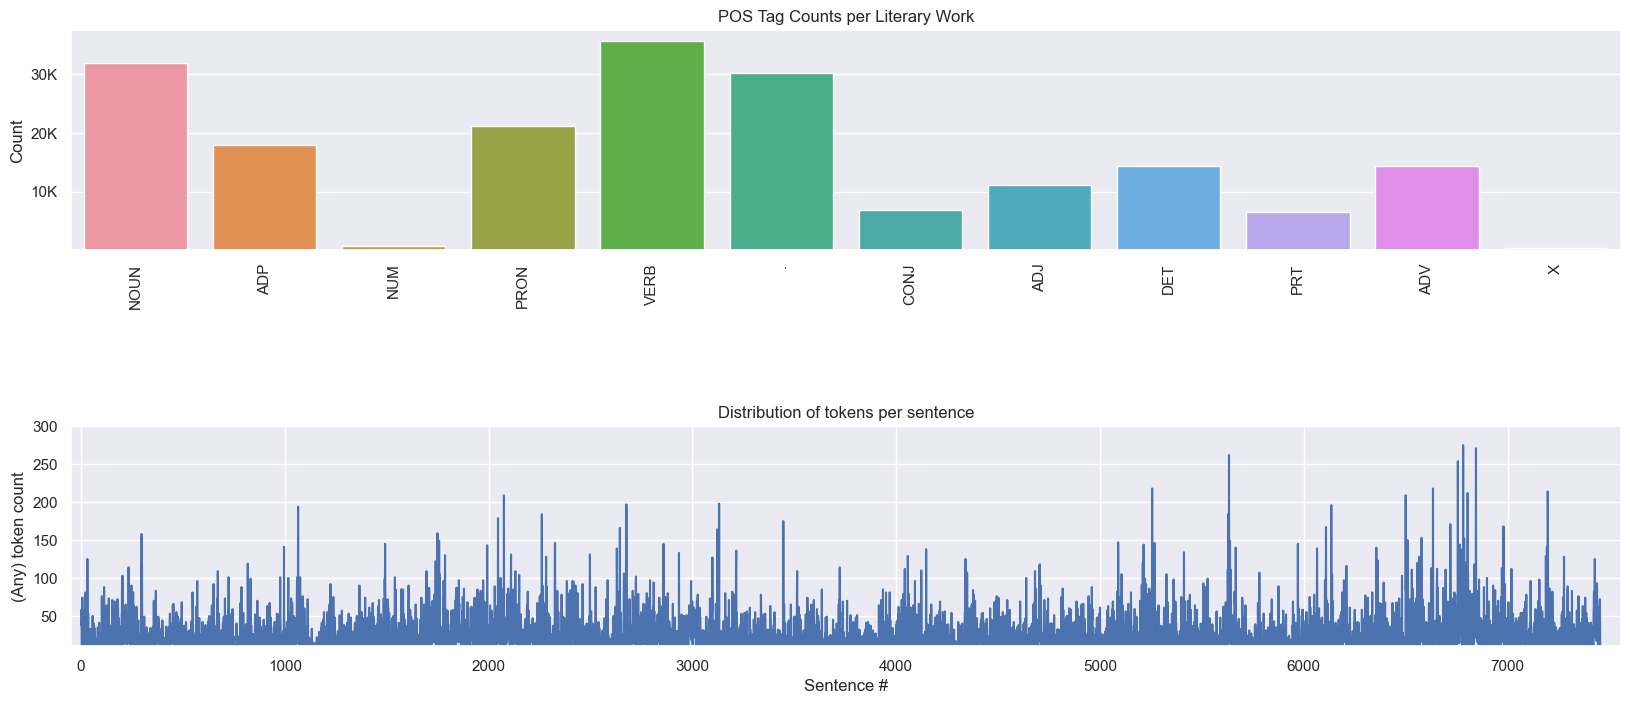

In [29]:
# Potentially consider color schemes for nounds, adjectives, etc., not just a random one
book_total_postags = bench.book_postag_counts(tagset='universal')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))
sns.barplot(x=list(book_total_postags.keys()), y=list(
    book_total_postags.values()), label="Emma", ax=ax1)
ax1.set_title("POS Tag Counts per Literary Work")
ax1.set_ylabel("Count")
ax1.set_ylim(bottom=30)
# Set counts to appear with the K suffix
ax1.yaxis.set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}K".format(int(x/1000))))
ax1.tick_params(axis='x', labelrotation=90)

num_tokens_per_sentence = np.array(list(bench.num_tokens_per_sentence()))
# x = np.arange(0, num_tokens_per_sentence.shape[0])
# spline = make_interp_spline(x, num_tokens_per_sentence, 3, bc_type='natural')
ax2.set(title="Distribution of tokens per sentence", xlabel="Sentence #",
        ylabel="(Any) token count", ylim=(10, 300), xlim=(-50, len(num_tokens_per_sentence) + 100))
ax2.plot(num_tokens_per_sentence)

fig.subplots_adjust(hspace=0.8)

# Average number of tokens per sentence
avg_num_tokens = bench.avg_tokens_per_sentence()


Possible algorithm for measuring number of tokens per sentence:
1. Split the text into sentences using the sentence tokenizer.
2. For each sentence, split it into tokens using the word tokenizer.

Additionally, plot the distribution of the number of tokens per sentence.
Additionally, plot the distribution of different PoS tags per sentence.
Do this for a few genres and compare them. PLOT PLOTS PLOTS


In [5]:
from typing import Tuple
def plot_postag_counts(df, fig=None, ax=None, **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    '''
    Plots a stackplot of the POS tag counts for each sentence in a book. Note: works best with a Pandas dataframe with the columns as the POS tags and the rows as the sentences.
    
    TODO: Optionally, set more options for modifying the figure, e.g. linewidth, color palette, etc.
    '''
    if fig is None or ax is None:
        fig, ax = plt.subplots(**kwargs)
    xnew = np.linspace(0, df.shape[0], 100)

    graphs = []
    # For each PosTag, create a smoothed line
    for label in df.columns:
        spl = make_interp_spline(
            list(df.index), df[label], bc_type='natural')  # BSpline object
        power_smooth = spl(xnew)

        graphs.append(power_smooth)

    ax.stackplot(xnew, *graphs, labels=df.columns, linewidth=0.1,
                colors=sns.color_palette("deep", n_colors=df.shape[1], as_cmap=True))

    ax.set(xbound=(0,df.shape[0]), ylim=(0, 1), title='Parts of Speech in Emma',
           xlabel='Sentence #', ylabel='Proportion of sentence')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(
        lambda x, loc: "{:.0%}".format(x/df.shape[0])))

    ax.legend()

    return fig, ax

# df = pd.DataFrame(bench.sent_postag_counts(tagset='universal'))
# Fill in any missing values with 0
# df.fillna(0, inplace=True)
# Divide each row by the sum of the row to get proportions
# df = df.div(df.sum(axis=1), axis=0)

fig, ax = plot_postag_counts(df, figsize=(20,8), dpi=400)
# fig.savefig(f'{plots_folder}pos_tag_counts.png', dpi=400)


NameError: name 'df' is not defined

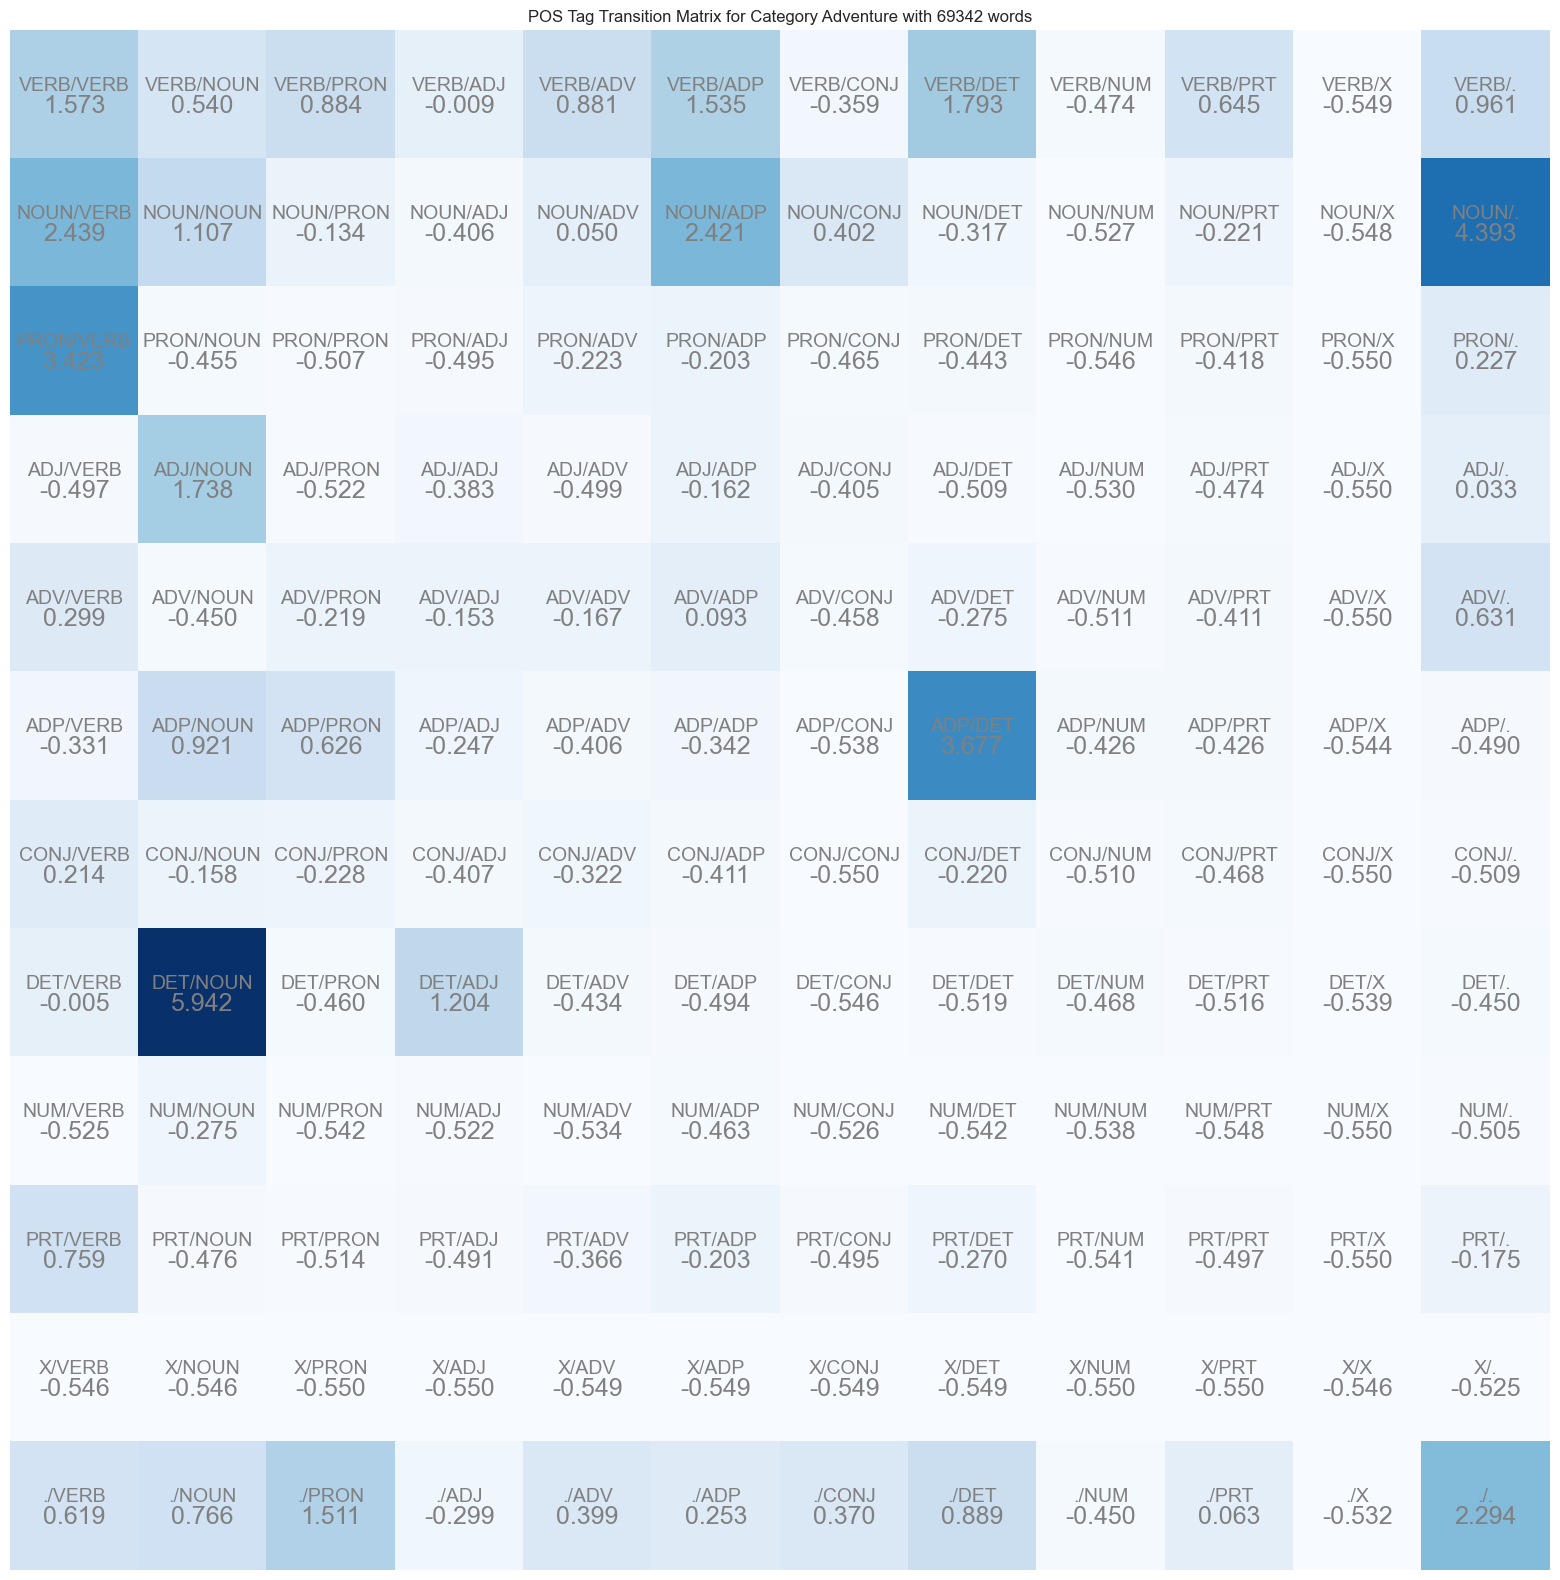

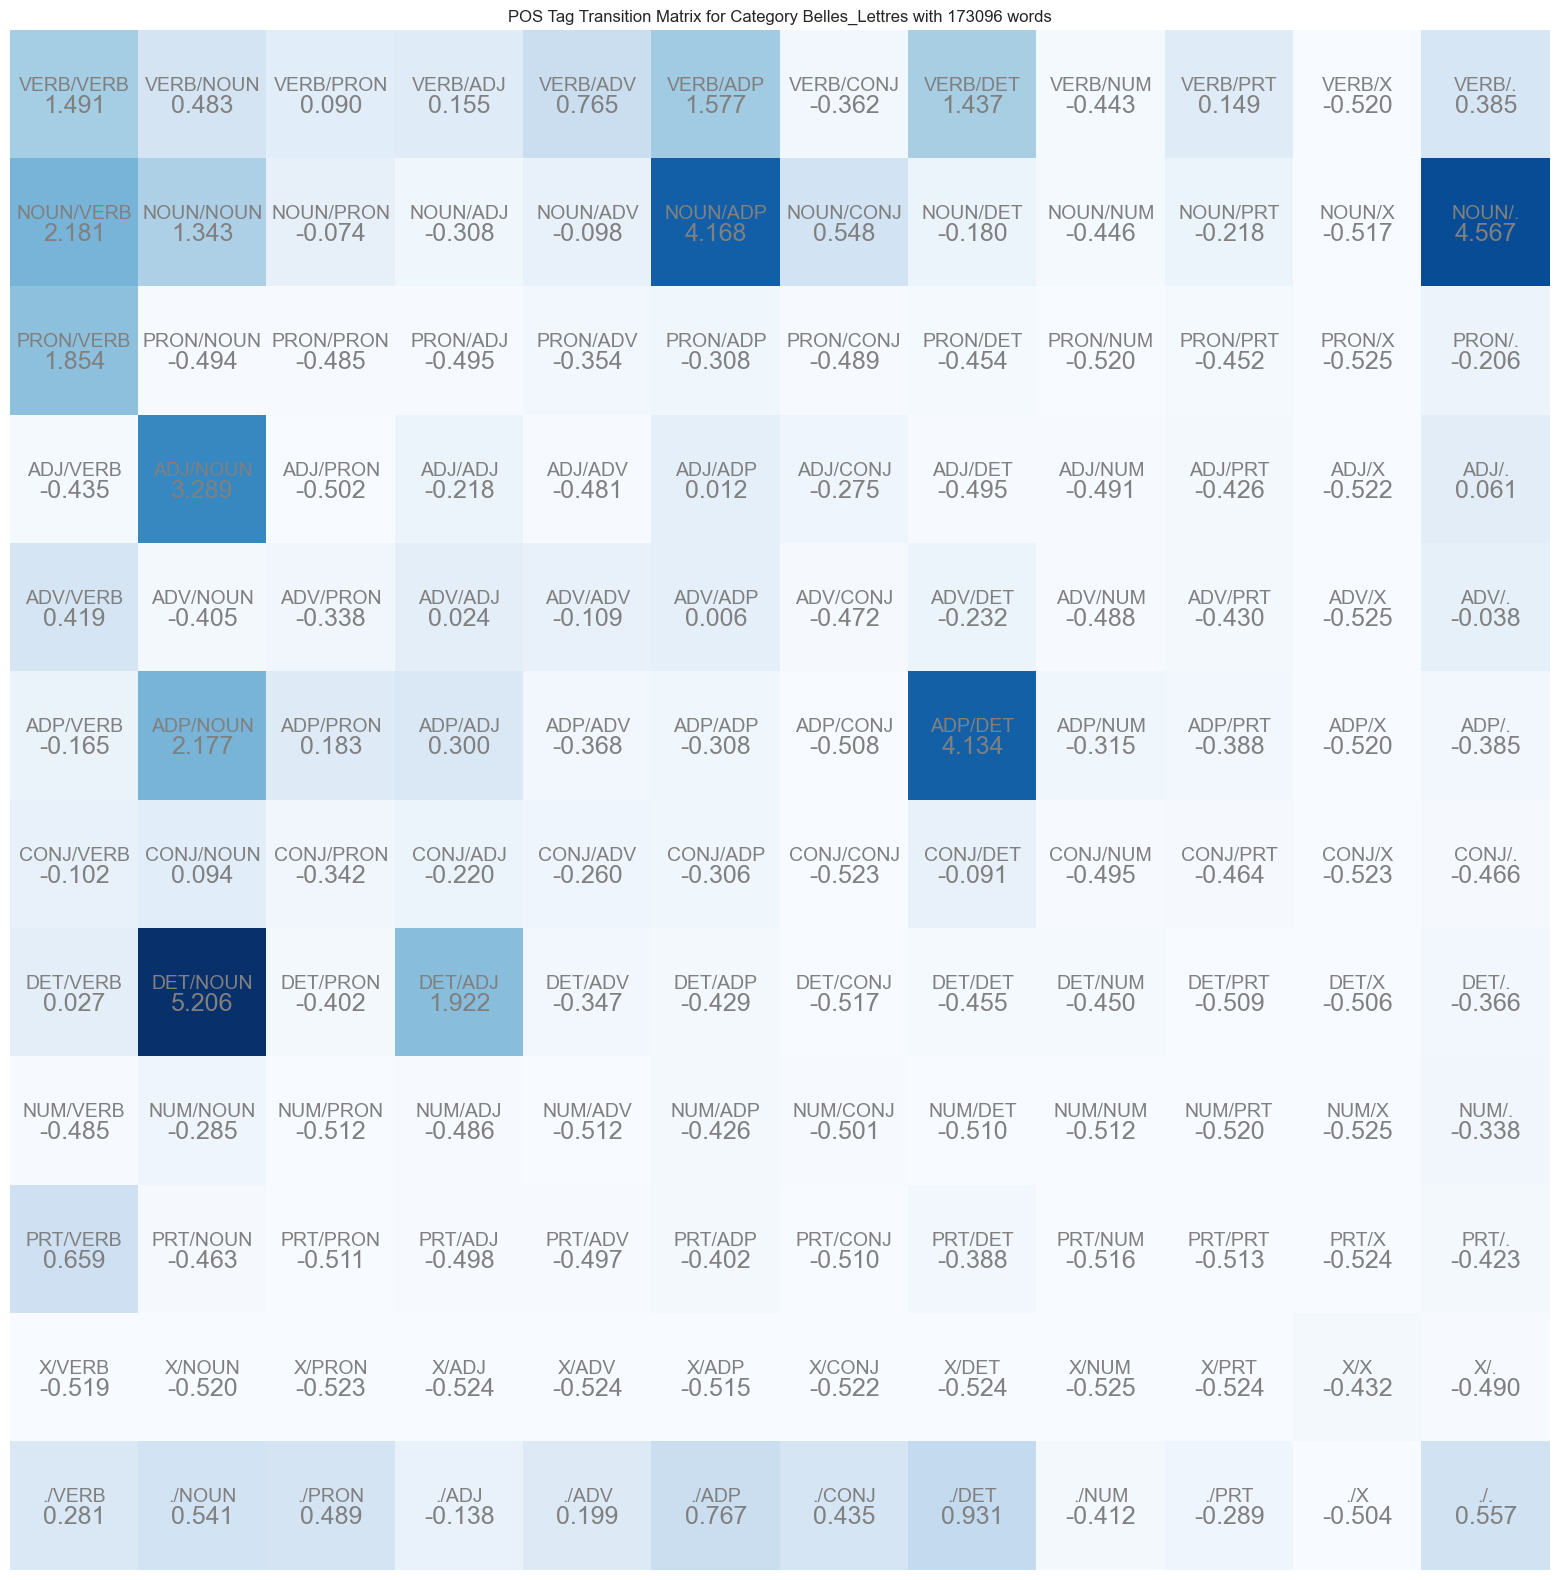

In [6]:
def plot_transition_matrix(tagged_words, title):
    """
    Plots a transition matrix for the POS tags in a book.
    """
    counter = torch.zeros((len(tags), len(tags)), dtype=torch.int32)
    for pair_1, pair_2 in zip(tagged_words, tagged_words[1:]):
        counter[tag_to_embed[pair_1[1]], tag_to_embed[pair_2[1]]] += 1
    counter = counter.clone().detach().double()
    counter = (counter - counter.mean()) / counter.std()
    # counter = counter.norm()
    plt.figure(figsize=(20, 20))
    plt.imshow(counter, cmap="Blues")
    for i in range(counter.shape[0]):
        for j in range(counter.shape[1]):
            plt.text(j, i, embed_to_tag[i]+'/'+embed_to_tag[j], ha="center",
                     va="bottom", color="gray", fontdict={'size': 14})
            plt.text(j, i, f"{counter[i, j].item():.3f}", ha="center",
                     va="top", color="gray", fontdict={'size': 18})
    plt.title(title)
    plt.axis('off')


for cat in brown.categories()[:2]:
    brown_words = brown.tagged_words(categories=cat, tagset='universal')
    plot_transition_matrix(
        brown_words, f"POS Tag Transition Matrix for Category {cat.title()} with {len(brown_words)} words")


### Distance measure based on semantic tree traversal
**Idea:**

- Given a sentence, tag words into parts of speech using the Universal tagset (we prefer not to use the PennTreebank tagset as it is too English-specific and would not mesh well with WordNet).
- Filter only to nouns, adjectives, verbs, and adverbs. 
- Given each tagged word, we find its synset (i.e. the set of synonyms) in WordNet.
- Compute some distance metric between the synsets of the two words. For example, we can use the [Wu-Palmer similarity](https://www.nltk.org/howto/wordnet.html) measure.
- How do we calculate that for all the words in a given text/sentence? 

#### Potential Issues
Potential issues with this approach may include:
- The use of WordNet. It is a good resource, but it is not perfect. For example, it does not contain all the words in the English language.
- Setting. For example, some words may not be subsititutable in certain context. Say, the collocation "big sister" cannot be replaced with "large sister" or "huge sister". It completely alters the meaning of the phrase. For example, the word H2O is used in scientific contexts and would be inappropriate in a hiking guide—water would be more appropriate— and this genre difference is part of the meaning of the word. In practice, the word syn- onym is therefore used to describe a relationship of approximate or rough synonymy. \cite{jurafsky2014speechorwhatever}
- 
- 

#### Additional Datasets
For example the SimLex-999 dataset (Hill et al., 2015) gives values on a scale from 0 to 10, like the examples below, which range from near-synonyms (vanish, disappear) to pairs that scarcely seem to have anything in common (hole, agreement):
| vanish | disappear | 9.8 |
|--------|-----------|-----|
| hole   | agreement | 1.2 |


Early work on affective meaning (Osgood et al., 1957) found that words varied along three important dimensions of affective meaning:
valence: the pleasantness of the stimulus
arousal: the intensity of emotion provoked by the stimulus dominance: the degree of control exerted by the stimulus

Osgood et al. (1957) noticed that in using these 3 numbers to represent the meaning of a word, the model was representing each word as a point in a three- dimensional space, a vector whose three dimensions corresponded to the word’s rating on the three scales. This revolutionary idea that word meaning could be rep- resented as a point in space (e.g., that part of the meaning of heartbreak can be represented as the point [2.45,5.65,3.58]) was the first expression of the vector se- mantics models that we introduce next. **You can paraphrase this**

In [7]:
# This implementation is shit, aye?
from nltk import wsd
import pywsd

sentence = "The quick brown fox jumps over the lazy dog"
words = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(words, tagset='universal')
universal_to_wn = {'NOUN': wn.NOUN, 'VERB': wn.VERB, 'ADJ': wn.ADJ, 'ADV': wn.ADV}
for word, tag in tagged:
    if tag not in universal_to_wn.keys():
        continue
    actual_word = pywsd.simple_lesk(sentence, word, universal_to_wn[tag])
    for method in [pywsd.simple_lesk, pywsd.cosine_lesk]:
        actual_word = method(sentence, word, universal_to_wn[tag])
        print(f"{word} - {tag} - {actual_word} - {actual_word.definition() if actual_word else ''}")
    # print(
    #     f"{word} - {tag} - {actual_word, actual_word.definition() if actual_word else ''} - {wn.synsets(word, pos=universal_to_wn[tag])}")


Warming up PyWSD (takes ~10 secs)... 

quick - ADJ - Synset('agile.s.01') - moving quickly and lightly
quick - ADJ - Synset('agile.s.01') - moving quickly and lightly
brown - NOUN - Synset('brown_university.n.01') - a university in Rhode Island
brown - NOUN - Synset('brown.n.01') - an orange of low brightness and saturation
fox - NOUN - Synset('fox.n.07') - the Algonquian language of the Fox
fox - NOUN - Synset('fox.n.03') - the grey or reddish-brown fur of a fox
jumps - VERB - Synset('startle.v.02') - move or jump suddenly, as if in surprise or alarm
jumps - VERB - Synset('jump.v.06') - enter eagerly into
lazy - ADJ - Synset('lazy.s.01') - moving slowly and gently
lazy - ADJ - Synset('lazy.s.01') - moving slowly and gently
dog - NOUN - Synset('pawl.n.01') - a hinged catch that fits into a notch of a ratchet to move a wheel forward or prevent it from moving backward
dog - NOUN - Synset('dog.n.01') - a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric time

took 5.7429609298706055 secs.


In [8]:
print(wn.ADJ)

a


Plot average concreteness of words in a sentence

^^ 
## Alternative implementation for semantic distance measure which abuses masked language models for context-aware words

In [11]:
from transformers import AutoTokenizer, BertForMaskedLM

import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = BertForMaskedLM.from_pretrained("bert-base-cased")


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
sent = "The quick brown fox jumps over the lazy dog."
masked_sent = sent.replace("fox", "[MASK]", 1)

inputs = tokenizer(masked_sent, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# retrieve index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[
    0].nonzero(as_tuple=True)[0]

vals, predicted_token_ids = torch.topk(logits[0, mask_token_index], 20, dim=-1)
# logits[0, mask_token_index].topk(axis=-1).argmax(axis=-1)
# print(vals)

# Tokenize the full sentence without the mask
labels = tokenizer(sent, return_tensors="pt")["input_ids"]
# mask labels of non-[MASK] tokens
labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, labels, -100)

print(masked_sent)
for i, predicted_token_id in enumerate(predicted_token_ids[0]):    
    # Compute the loss for each item
    outputs = model(**inputs, labels=labels)
    print(
        f"Prediction {i+1:>2}:  {tokenizer.decode(predicted_token_id):>6} - Loss: {outputs.loss.item():.3f}  - Likelihood {vals[0][i].item():.3f}")

    

The quick brown [MASK] jumps over the lazy dog.
Prediction  1:     dog - Loss: 3.460  - Likelihood 12.198
Prediction  2:    ##ie - Loss: 3.460  - Likelihood 11.229
Prediction  3:     cat - Loss: 3.460  - Likelihood 10.601
Prediction  4:    bear - Loss: 3.460  - Likelihood 10.128
Prediction  5:   puppy - Loss: 3.460  - Likelihood 10.012
Prediction  6:  Labrador - Loss: 3.460  - Likelihood 9.975
Prediction  7:    mare - Loss: 3.460  - Likelihood 9.920
Prediction  8:     fox - Loss: 3.460  - Likelihood 9.891
Prediction  9:   horse - Loss: 3.460  - Likelihood 9.877
Prediction 10:    coat - Loss: 3.460  - Likelihood 9.633
Prediction 11:    wolf - Loss: 3.460  - Likelihood 9.359
Prediction 12:  ##hound - Loss: 3.460  - Likelihood 9.158
Prediction 13:  stallion - Loss: 3.460  - Likelihood 8.907
Prediction 14:     man - Loss: 3.460  - Likelihood 8.770
Prediction 15:     rat - Loss: 3.460  - Likelihood 8.711
Prediction 16:   ##ies - Loss: 3.460  - Likelihood 8.686
Prediction 17:     one - Loss:

In [13]:
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero()[0]
mask_token_index


tensor([4])

## Similar idea, but sentence-level instead of word-level
Use `BertForNextSentencePrediction` to determine how "unpredictable" the following sentence is given the previous sentence (as prompt). We mask the second sentence and take something like a cosine similarity / set difference between the two vectors.

In [14]:
from transformers import AutoTokenizer, BertForNextSentencePrediction
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "The sky is blue due to the shorter wavelength of blue light."

encoding = tokenizer(prompt, next_sentence, return_tensors="pt")
outputs = model(**encoding, labels=torch.LongTensor([1]))

logits = outputs.logits
print(logits[0, 0], logits[0, 1])  # next sentence was random


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor(-3.0729, grad_fn=<SelectBackward0>) tensor(5.9056, grad_fn=<SelectBackward0>)


## Notes
- What current approaches to creativity evaluation have been implemented so far?

### Related Work
- Current methods/similar work with POS tags, proof that POS tags are (not) enough to capture creativity


### Putting some ideas of the notebook into the thesis

### Write down some methodology or datasets 

### Write down some datasets for the experiment

### Draw some comparisons between the suggested replacements in the masked model - maybe mean, cosine similarity, etc.
- Maybe use stuff like word2vec to show differences between the words

brown.categories()

In [15]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']